In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

In [2]:
from scipy import stats
import scikit_posthocs as sp

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv("settles.acl16.learning_traces.13m.csv")
print(len(df))
df.head()

12854226


,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct
0,1.0,1362076081,27649635,u:FO,de,en,76390c1350a8dac31186187e2fe1e178,lernt/lernen<vblex><pri><p3><sg>,6,4,2,2
1,0.5,1362076081,27649635,u:FO,de,en,7dfd7086f3671685e2cf1c1da72796d7,die/die<det><def><f><sg><nom>,4,4,2,1
2,1.0,1362076081,27649635,u:FO,de,en,35a54c25a2cda8127343f6a82e6f6b7d,mann/mann<n><m><sg><nom>,5,4,1,1
3,0.5,1362076081,27649635,u:FO,de,en,0cf63ffe3dda158bc3dbd55682b355ae,frau/frau<n><f><sg><nom>,6,5,2,1
4,1.0,1362076081,27649635,u:FO,de,en,84920990d78044db53c1b012f5bf9ab5,das/das<det><def><nt><sg><nom>,4,4,1,1


# Q2: Difference between groups of users learning just single language and more than one langauges

In [5]:
user_grouped = list(df.groupby("user_id"))

In [6]:
learning_language_pairs = set()
for user in tqdm(user_grouped):
    learning_language_pairs.add(tuple(user[1].learning_language.unique().tolist()))

  0%|          | 0/115222 [00:00<?, ?it/s]

In [7]:
learning_language_pairs_stats = {x:0 for x in learning_language_pairs}
for user in tqdm(user_grouped):
    pair = tuple(user[1].learning_language.unique().tolist())
    learning_language_pairs_stats[pair] += 1

  0%|          | 0/115222 [00:00<?, ?it/s]

In [8]:
# Most combinations are very rare, only have one or two users
learning_language_pairs = set(filter(lambda x: learning_language_pairs_stats[x] >= 100, learning_language_pairs))

In [9]:
learning_language_pairs

{('de',),
 ('de', 'es'),
 ('de', 'fr'),
 ('en',),
 ('es',),
 ('es', 'de'),
 ('es', 'fr'),
 ('fr',),
 ('fr', 'de'),
 ('fr', 'es'),
 ('it',),
 ('pt',)}

In [10]:
user_grouped = list(df.groupby("user_id"))

In [11]:
data = {x:[] for x in learning_language_pairs}


for user in tqdm(user_grouped):
    lexeme_grouped = user[1].groupby("lexeme_id")
    pair = tuple(user[1].learning_language.unique().tolist())
    
    if pair not in learning_language_pairs:
        continue

    user_performance = []
    for lexeme in lexeme_grouped:
        last_entry = lexeme[1].iloc[-1]
        user_performance.append(last_entry.history_correct/last_entry.history_seen)
    user_performance_aggregate = np.mean(user_performance)
    data[pair].append(user_performance_aggregate)

  0%|          | 0/115222 [00:00<?, ?it/s]

In [12]:
stats.levene(*[data[x] for x in data])

LeveneResult(statistic=77.76656711570136, pvalue=1.1228786547780472e-175)

In [13]:
stats.kruskal(*[data[x] for x in data])

KruskalResult(statistic=906.9016887870584, pvalue=2.0354078062826345e-187)

In [30]:
labels =  [("de", "es"), ("de", ), ("es", )]
# labels =  [("de", "fr"), ("de", ), ("fr", )]
# labels =  [("es", "fr"), ("es", ), ("fr", )]


In [31]:
stats.levene(*[data[x] for x in labels])

LeveneResult(statistic=10.278383010781987, pvalue=3.44532673265469e-05)

In [32]:
stats.kruskal(*[data[x] for x in labels])

KruskalResult(statistic=44.03360966582194, pvalue=2.7429832268093247e-10)

In [33]:
sp.posthoc_mannwhitney([data[x] for x in labels], p_adjust = 'bonferroni')

,1,2,3
1,1.000000,9.757054e-01,1.239939e-01
2,0.975705,1.000000e+00,4.490072e-10
3,0.123994,4.490072e-10,1.000000e+00


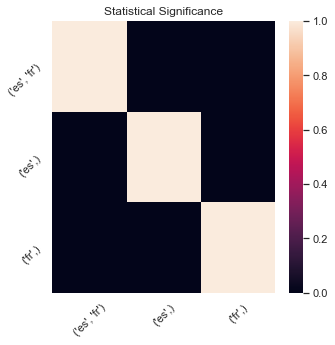

In [28]:
# ax = sns.heatmap((np.array(sp.posthoc_dunn([data[x] for x in labels], p_adjust = 'bonferroni')) <= 0.05))
ax = sns.heatmap((np.array(sp.posthoc_dunn([data[x] for x in labels], p_adjust = 'bonferroni'))))

ax.set_xticklabels([str(x) for x in labels])
ax.set_yticklabels([str(x) for x in labels])

ax.set_title("Statistical Significance")

sns.set(rc={'figure.figsize':(5,5)})
plt.xticks(rotation=45)
plt.yticks(rotation=45);

In [29]:
(np.array(sp.posthoc_dunn([data[x] for x in labels], p_adjust = 'bonferroni')))

array([[1.00000000e+00, 1.05230486e-05, 1.19673370e-13],
       [1.05230486e-05, 1.00000000e+00, 3.03944938e-65],
       [1.19673370e-13, 3.03944938e-65, 1.00000000e+00]])

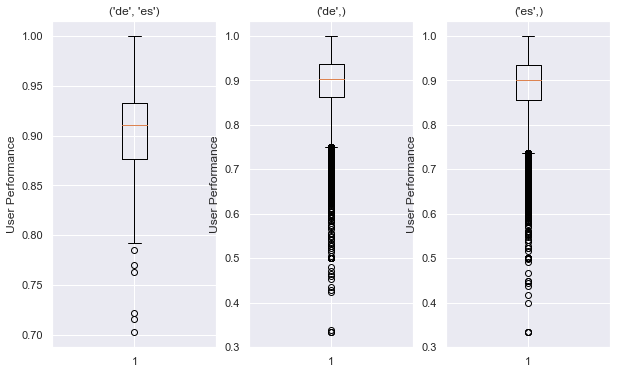

In [129]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6))

for i in range(len(axs)):
    axs[i].boxplot(data[labels[i]])
    axs[i].set_title(str(labels[i]))
    axs[i].set_ylabel("User Performance")

In [130]:
print(*list(enumerate(data.keys())), sep='\n')

(0, ('es', 'de'))
(1, ('pt',))
(2, ('es',))
(3, ('en',))
(4, ('fr',))
(5, ('es', 'fr'))
(6, ('fr', 'de'))
(7, ('de', 'es'))
(8, ('fr', 'es'))
(9, ('de', 'fr'))
(10, ('it',))
(11, ('de',))
